In [1]:
import numpy as np ##importing libraries
import os
import matplotlib.pyplot as plt
import cv2
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.nn import Linear, ReLU, MSELoss, L1Loss, Sequential, Conv2d, ConvTranspose2d, MaxPool2d, AdaptiveAvgPool2d, Module,BatchNorm2d, Sigmoid, Dropout
from torchvision.utils import make_grid

In [2]:
# The code for different attention modules are referenced from this repository: https://github.com/changzy00/pytorch-attention?tab=readme-ov-file#Attention-mechanisms

from torch.nn.parameter import Parameter
import torch.nn.functional as F  

class L2(nn.Module):
    def __init__(self, dim=1, eps=1e-12):
        super(L2, self).__init__()
        self.dim = dim
        self.eps = eps

    def forward(self, x):
        return F.normalize(x, p=2, dim=self.dim, eps=self.eps)


class Sim(torch.nn.Module):
    def __init__(self, channels=None, e_lambda = 1e-4):
        super(Sim, self).__init__()

        self.activaton = nn.Sigmoid()
        self.e_lambda = e_lambda
        

    def __repr__(self):
        s = self.__class__.__name__ + '('
        s += ('lambda=%f)' % self.e_lambda)
        return s

    @staticmethod
    def get_module_name():
        return "simam"

    def forward(self, x):

        b, c, h, w = x.size()
       
        n = w * h - 1

        x_minus_mu_square = (x - x.mean(dim=[2,3], keepdim=True)).pow(2)
        y = x_minus_mu_square / (4 * (x_minus_mu_square.sum(dim=[2,3], keepdim=True) / n + self.e_lambda)) + 0.5

        return x*self.activaton(y)

#class bp(nn.Module):
    # def __init__(self,channel):
        # super().__init__()
        # self.channel=channel
        # self.conv=nn.Conv2d(channel,channel,kernel_size=1)
        # self.L2=L2()
        # self.convV=nn.Conv2d(channel,channel,kernel_size=1)

    # def forward(self,x):
    #     b,c,h,w=x.shape
    #     A=self.conv(x)
    #     V=self.convV(x)
    #     av=V.view(b,c,h*w)
    #     temA=A.view(b,c,h*w)
    #     x11=x.view(b,c,h*w)
    #     blp=temA.bmm(x11.transpose(1,2))
    #     tmpz=blp.matmul(av)
    #     tmpz=tmpz.view(b,c,h,w)
    #     blp_l=self.L2(tmpz)
    #     return blp_l


import math
class Sim_SA(torch.nn.Module):
    def __init__(self,channel):
        super(Sim_SA,self).__init__()
        self.sim=Sim()
        self.channel=channel
        self.convQ=nn.Conv2d(channel,1,kernel_size=1)
        self.convK=nn.Conv2d(channel,1,kernel_size=1)
        self.convV=nn.Conv2d(1,1,kernel_size=1)
        self.conv=nn.Conv2d(channel,channel,kernel_size=1)
        self.L2=L2()
        self.gamma = nn.Parameter(torch.zeros(1))
        self.softmax  = nn.Softmax(dim=-1)
        #self.convK=nn.Conv2d(channel,channel,kernel_size=1,dilation=2)
        #self.bp=bp(channel)
        self.sigmoid = nn.Sigmoid()
        self.relu=nn.ReLU(inplace=True),
        # self.fc = nn.Sequential(
        #     nn.Linear(channel, channel // 16, bias=False),
        #     nn.ReLU(inplace=True),
        #     nn.Linear(channel // 16, channel, bias=False),
        #     nn.Sigmoid()
        # )
       
    def forward(self, x):
        b,c,h,w=x.shape
        y=self.sim(x)
        x1=self.L2(y)
        q=self.convQ(x1)
        q1=self.sigmoid(q)
        k=self.convK(x1)
        k1=self.sigmoid(k)
        # vv=self.conv(x1)
        # v1=self.sim(vv)
        # v=self.L2(v1)
        a1=q1*k1
        a2=self.convV(a1)
        a3=x1*a2
        # a3=x1*a1
        #a5=x*a2
        a4=a3+x1
        return a4
        
        
        

        
        
    
    

In [3]:
##unet model + Sim_SA
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):

        super().__init__()

        self.conv1=nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.SIM1=Sim_SA(out_c)

        self.bn1=nn.BatchNorm2d(out_c)
        self.conv2=nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.SIM2=Sim_SA(out_c)

        self.bn2=nn.BatchNorm2d(out_c)
        self.relu=nn.ReLU()



    def forward(self, inputs):
        x=self.conv1(inputs)
        ##attention
        x=self.SIM1(x)
        x=self.bn1(x)
        x=self.relu(x)
        x=self.conv2(x)
        ##attention
        x=self.SIM2(x)
        x=self.bn2(x)
        x=self.relu(x)
        return x

class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):

        super().__init__()
        self.conv=conv_block(in_c,out_c)
        self.dropout=nn.Dropout(0.25)###dropout layer?? use it ;
        self.pool=nn.MaxPool2d((2,2))

    def forward(self, inputs):
        x=self.conv(inputs)
        x=self.dropout(x)##dropout??
        p=self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):


        super().__init__()
        self.up=nn.ConvTranspose2d(in_c, out_c,kernel_size=2, stride=2, padding=0)
        self.SIM3=Sim_SA(out_c)
        self.conv=conv_block(out_c+out_c, out_c)
        
    def forward(self, inputs, skip):
        x=self.up(inputs)
        skip=self.SIM3(skip)###attention??
        x=torch.cat([x,skip], axis=1)
        x=self.conv(x)
        return x

class build_SIM_SA(nn.Module):
    def __init__(self):
        super().__init__()

        ##encoder block
        self.e1=encoder_block(1,32)##3channels?/
        self.e2=encoder_block(32,64)
        self.e3=encoder_block(64,128)
        self.e4=encoder_block(128,256)
        self.b=conv_block(256,512)
        self.d1=decoder_block(512,256)
        self.d2=decoder_block(256,128)
        self.d3=decoder_block(128,64)
        self.d4=decoder_block(64,32)
        self.outputs=nn.Conv2d(32,1,kernel_size=1,padding=0)

    def forward(self, inputs):
        s1,p1=self.e1(inputs)
        s2,p2=self.e2(p1)
        s3,p3=self.e3(p2)
        s4,p4=self.e4(p3)
        b=self.b(p4)
        d1=self.d1(b,s4)
        d2=self.d2(d1,s3)
        d3=self.d3(d2,s2)
        d4=self.d4(d3,s1)
        outputs=self.outputs(d4)
        return outputs


In [4]:
torch.set_flush_denormal(True)

True

In [5]:
##training script
##importing libraries
import random
import time

In [6]:
np.random.seed(42)
torch.manual_seed(42)

In [7]:
path='C:/Users/ah_wo/Attention_experiments/single_coil_train_val/'

pth_noisy = 0.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/0.png
pth_noisy = 1.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/1.png
pth_noisy = 10.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/10.png
pth_noisy = 100.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/100.png
pth_noisy = 101.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/101.png
pth_noisy = 102.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/102.png
pth_noisy = 103.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/train_lax_renamed_ALL/target_FS/103.png
pth_noisy = 104.png
path_clean= C:/Users/ah_wo/Attention_experiments/single_coil_train_val/tr

c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


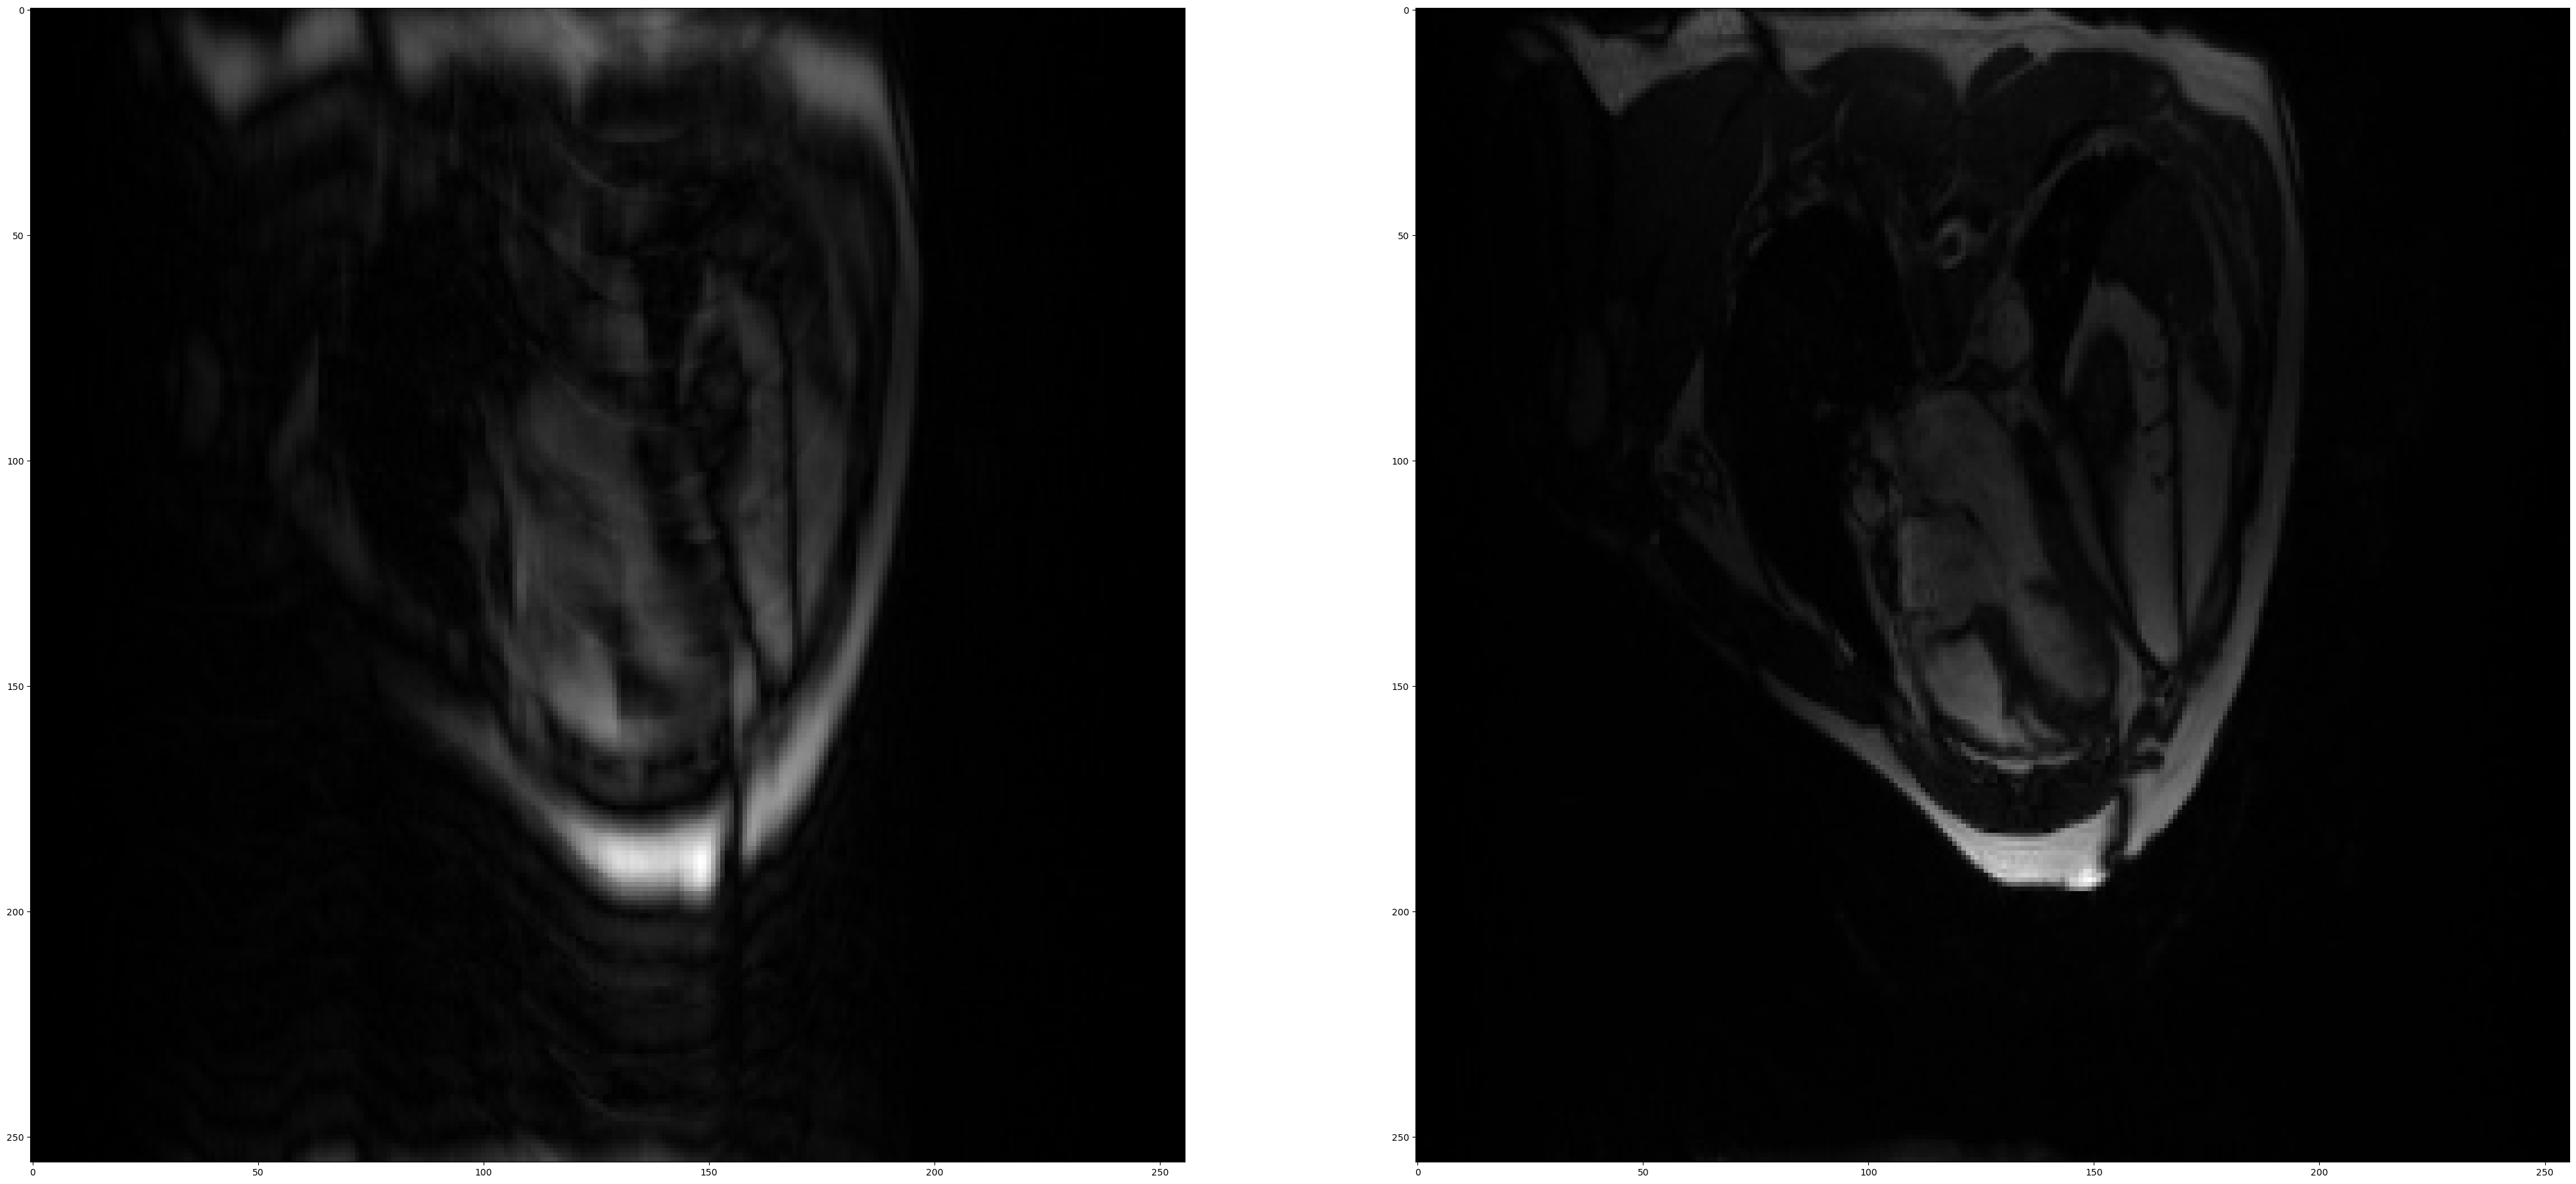

In [8]:
##data loader class
class DataLoader_Class:
    def __init__(self, path):
        self.path=path
        self.train_images=[]
        self.train_cleaned=[]
        self.test_images=[]
        self.test_cleaned=[]

    def read_all_images(self):
        self.train_images_path=[(self.path  + 'train_lax_renamed_ALL/input_AC/' + f)
                                   for f in sorted(os.listdir(self.path + 'train_lax_renamed_ALL/input_AC/'))]
        self.train_cleaned_path = [(self.path  + 'train_lax_renamed_ALL/target_FS/' + f)
                                   for f in sorted(os.listdir(self.path + 'train_lax_renamed_ALL/target_FS/'))]

        self.test_images_path  = [(self.path  + 'val_lax_renamed_ALL/input_AC/' + f)
                                   for f in sorted(os.listdir(self.path + 'val_lax_renamed_ALL/input_AC/'))]

        self.test_cleaned_path = [(self.path  + 'val_lax_renamed_ALL/target_FS/' + f)
                                   for f in sorted(os.listdir(self.path + 'val_lax_renamed_ALL/target_FS/'))]

        transform = transforms.Compose([
            transforms.ToTensor(),
            #rotation_transform(),
            #transforms.Normalize((0.5, ), (0.5, )),
        ])

        for path in self.train_images_path:
            pth_noisy=path.split('/')[-1]
            print('pth_noisy =',pth_noisy)
            fname=pth_noisy.split('.')[0]
            path_clean=path.replace('input_AC','target_FS')
            print('path_clean=',path_clean)

            img=cv2.imread(path)
            img=np.asarray(img, dtype="uint8")
            img=cv2.resize(img, (256,256))
            img=(img-np.min(img))/(np.max(img)-np.min(img))
            img=img[:,:,0]##1 channel only??


            img_cleaned=cv2.imread(path_clean)
            img_cleaned=np.asarray(img_cleaned,dtype="uint8")
            img_cleaned=cv2.resize(img_cleaned, (256,256))##256,256
            img_cleaned=(img_cleaned-np.min(img_cleaned))/(np.max(img_cleaned)-np.min(img_cleaned))
            img_cleaned=img_cleaned[:,:,0]

            img=transforms.ToTensor()(img.astype('float32'))
            clean_img=transforms.ToTensor()(img_cleaned.astype('float32'))

            ##no rotation transform

            self.train_images.append(img)
            self.train_cleaned.append(clean_img)

        for path in self.test_images_path:
            img=cv2.imread(path)
            print('test_images_path = ',path)
            img=np.asarray(img, dtype="uint8")
            img=cv2.resize(img, (256,256))
            img= (img-np.min(img))/(np.max(img)-np.min(img))
            img=img[:,:,0]
            img=transforms.ToTensor()(img.astype('float32'))

            self.test_images.append(img)

        for path in self.test_cleaned_path:
            img=cv2.imread(path)
            img=np.asarray(img, dtype="uint8")
            img=cv2.resize(img, (256,256))
            img=(img-np.min(img))/(np.max(img)-np.min(img))
            img=img[:,:,0]
            img=transforms.ToTensor()(img.astype('float32'))
            self.test_cleaned.append(img)


        ###convert to tensor
        self.train_images=torch.stack(self.train_images)
        self.train_cleaned=torch.stack(self.train_cleaned)
        self.test_images=torch.stack(self.test_images)
        self.test_cleaned=torch.stack(self.test_cleaned)

        print(self.train_images.shape)
        print(self.train_cleaned.shape)
        print(self.test_images.shape)
        print(self.test_cleaned.shape)

        return self.train_images, self.train_cleaned, self.test_images, self.test_cleaned

    def see_an_image(self, number):
        f, axarr=plt.subplots(1,2, figsize=(50,100))
        axarr[0].imshow(self.train_images[number].permute(1,2,0),cmap="gray")
        axarr[1].imshow(self.train_cleaned[number].permute(1,2,0),cmap="gray")

data_loader=DataLoader_Class(path)
train_set_x, train_set_y, test_set_x, test_set_y= data_loader.read_all_images()
data_loader.see_an_image(0)

In [9]:
batch_size=2
from torch.utils.data import Dataset

In [10]:
class Dataset_AE(Dataset):
    def __init__(self, X_train, y_train):
        self.X_train=X_train
        self.y_train=y_train
        
    def __len__(self):
        return len(self.y_train)
    
    def __getitem__(self, idx):
        return self.X_train[idx], self.y_train[idx]
    
training_set=Dataset_AE(train_set_x, train_set_y)
train_loader=torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
test_set=Dataset_AE(test_set_x, test_set_y)
test_loader=torch.utils.data.DataLoader(test_set,batch_size=batch_size, shuffle=False)

In [11]:
##model definition
model=build_SIM_SA()

In [12]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [13]:
from typing import Optional
from skimage.metrics import peak_signal_noise_ratio, structural_similarity
EPS=1e-7
def PSNR(input, target):
    return -10*torch.log10(torch.mean((input - target) ** 2, dim=[1, 2, 3])+EPS)
def MSE(input, target):
    return torch.mean((input - target) ** 2, dim=[1, 2, 3])
def ssim(
    gt: np.ndarray, pred: np.ndarray, maxval: Optional[float] = None
) -> np.ndarray:
    """Compute Structural Similarity Index Metric (SSIM)"""
    if maxval is None:
        maxval = gt.max()
    return structural_similarity(gt, pred, data_range=maxval)



c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
c:\Users\ah_wo\anaconda3\Lib\site-packages\numpy\core\getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


In [14]:
##saving path
save_path = 'C:/Users/ah_wo/Attention_experiments/New_results/Proposed/'

In [15]:
def train(model, num_epochs=5, batch_size=2, learning_rate=0.001):#was 0.001 and gave better results

    criterion = nn.MSELoss() # mean square error loss
    #criterion = MS_SSIM_L1_LOSS()

    optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.95)

    early_stopper = EarlyStopper(patience=3, min_delta=10)#was min_delta=10
    outputs = []
    loss_arr= []
    val_loss_arr=[]

    psnr = []
    mse = []
    SSIM_arr=[]

    psnr_all = []
    mse_all = []

    val_psnr = []
    val_mse = []
    val_SSIM_arr=[]

    val_psnr_all = []
    val_mse_all = []

    for epoch in tqdm(range(num_epochs)):

        for data in train_loader:
            img, _ = data

            img, _ = img.cuda(), _.cuda()

            optimizer.zero_grad()
            recon = model(img)
            

            loss = criterion(recon, _)
            loss.backward()
            #nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

            psnr.extend(PSNR(_.cpu().detach(), recon.cpu().detach()))
            mse.extend(MSE(_.cpu().detach(), recon.cpu().detach()))

        psnr_all.append(np.array(psnr).mean())
        mse_all.append(np.array(mse).mean())

        for data in test_loader:
            with torch.no_grad():
                img, _ = data
                img, _ = img.cuda(), _.cuda()
                recon_val = model(img)
                loss_val = criterion(recon_val, _)

                val_psnr.extend(PSNR(_.cpu().detach(), recon_val.cpu().detach()))
                val_mse.extend(MSE(_.cpu().detach(), recon_val.cpu().detach()))

        val_psnr_all.append(np.array(val_psnr).mean())
        val_mse_all.append(np.array(val_mse).mean())

        #-- EARLY STOPPING ------------------------------------------------------------
        if early_stopper.early_stop(loss_val):
            break
#------------------------------------------------------------------------------
        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
        loss_arr.append(float(loss))
        val_loss_arr.append(float(loss_val))

    return outputs, loss_arr, val_loss_arr, np.array(psnr_all), np.array(mse_all), np.array(val_psnr_all), np.array(val_mse_all)


In [16]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device= 'cpu'
    return device

In [17]:
device=get_device()
print(device)

cuda:0


In [18]:
seed=42
if device == "cuda:0":
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch:1, Loss:0.0016
Epoch:2, Loss:0.0028
Epoch:3, Loss:0.0008
Epoch:4, Loss:0.0009
Epoch:5, Loss:0.0010
Epoch:6, Loss:0.0006
Epoch:7, Loss:0.0004
Epoch:8, Loss:0.0005
Epoch:9, Loss:0.0008
Epoch:10, Loss:0.0008
Epoch:11, Loss:0.0005
Epoch:12, Loss:0.0003
Epoch:13, Loss:0.0005
Epoch:14, Loss:0.0006
Epoch:15, Loss:0.0004
Epoch:16, Loss:0.0004
Epoch:17, Loss:0.0004
Epoch:18, Loss:0.0005
Epoch:19, Loss:0.0003
Epoch:20, Loss:0.0007
Epoch:21, Loss:0.0004
Epoch:22, Loss:0.0003
Epoch:23, Loss:0.0002
Epoch:24, Loss:0.0003
Epoch:25, Loss:0.0005
Epoch:26, Loss:0.0003
Epoch:27, Loss:0.0002
Epoch:28, Loss:0.0003
Epoch:29, Loss:0.0002
Epoch:30, Loss:0.0003
Epoch:31, Loss:0.0003
Epoch:32, Loss:0.0002
Epoch:33, Loss:0.0003
Epoch:34, Loss:0.0001
Epoch:35, Loss:0.0003
Epoch:36, Loss:0.0002
Epoch:37, Loss:0.0003
Epoch:38, Loss:0.0001
Epoch:39, Loss:0.0003
Epoch:40, Loss:0.0002
Epoch:41, Loss:0.0002
Epoch:42, Loss:0.0002
Epoch:43, Loss:0.0002
Epoch:44, Loss:0.0003
Epoch:45, Loss:0.0002
Epoch:46, Loss:0.00

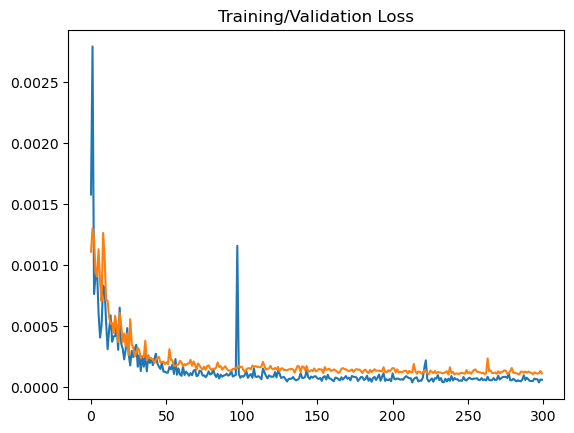

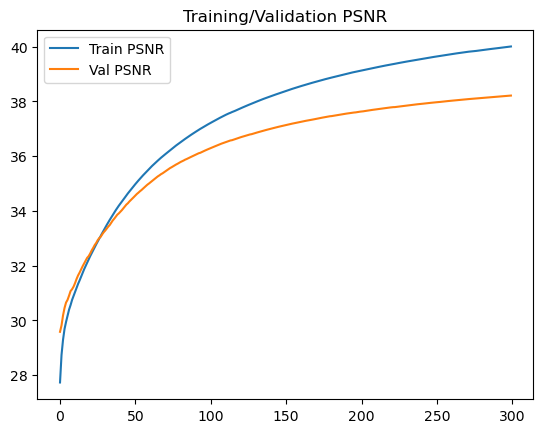

In [19]:
model.to(device)
start=time.time()
outputs, loss_arr, val_loss_arr, psnr, mse, val_psnr, val_mse = train(model, num_epochs=300)# was 300 for MSE
end=time.time()
print('training time = ',end-start)

torch.save(model.state_dict(), 'proposed_eusipco_lax.pt')

plt.figure(),plt.plot(np.asarray(loss_arr)),plt.plot(np.asarray(val_loss_arr)),plt.title('Training/Validation Loss')
plt.savefig('train_val_loss_withDropout.png')
plt.figure(),plt.plot(np.asarray(psnr),label='Train PSNR'),plt.plot(np.asarray(val_psnr),label='Val PSNR'),plt.title('Training/Validation PSNR')
plt.legend()
plt.savefig('train_val_PSNR_withDropout.png')
total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

In [24]:
def eval_model(model, test_loader):
    model.eval()
    psnr= []
    mse= []
    SSIM_arr=[]
    with torch.no_grad():
        j=0
        SSIM=[]
        for noisy_images, targets in test_loader:
            targets= targets.to(device)
            noisy_images= noisy_images.to(device)
            preds=model(noisy_images)
            predictions=preds.cpu().detach().numpy()
            ln=len(predictions)
            print('len_predictions=',ln)
            print('predictions_shape', np.shape((np.moveaxis(predictions,1,-1))))
            for l in range(0,ln):
                p=(np.moveaxis(predictions[l],1,-1))
                p=np.expand_dims(p,axis=-1)
                p=np.concatenate((p,p,p),axis=-1)
                p=np.squeeze(p,axis=0)
                p=(p-np.min(p))/(np.max(p)-np.min(p))
                print('np.max(p)=',np.max(p))
                print('np_shape(p)',np.shape(p))
                p=np.moveaxis(p,0,1)
                print(save_path+str(2*j+l)+'_predict.jpg')
                p=cv2.resize(p,(448,206))
                cv2.imwrite(save_path+str(2*j+l)+'_predict.jpg',p*255)
                # j+=1
            
           
            psnr.extend(PSNR(targets.cpu().detach(), preds.cpu().detach()))
            mse.extend(MSE(targets.cpu().detach(),preds.cpu().detach()))
            j+=1

            t=targets.cpu().detach().numpy()
            pr=preds.cpu().detach().numpy()
            t=np.squeeze(t,axis=1)
            pr=np.squeeze(pr,axis=1)
            for l in range(0,ln):
                s=ssim(t[l,:,:], pr[l,:,:])
                SSIM.append(s)
            # j+=1
        SSIM_arr.append(SSIM)
        print(f"PSNR: Mean: {np.array(psnr).mean()} || Std: {np.array(psnr).std()}")
        print(f"MSE: Mean: {np.array(mse).mean()} || Std: {np.array(mse).std()}")

        return np.array(psnr).mean(), np.array(mse).mean(), SSIM_arr, predictions

In [25]:
##predictions
recon_model= build_SIM_SA()
state_dict= torch.load('proposed_eusipco_lax.pt')
recon_model.load_state_dict(state_dict)
normal_ae_mse= recon_model.to(device)
psnr=[]
with torch.no_grad():
    for i, (images, targets) in enumerate(test_loader):
        noisy_images= images
        noisy_images=noisy_images.to(device)
        targets=targets.to(device)
        preds=recon_model(noisy_images)
        if (i<30):#??
            print(PSNR(targets.cpu().detach(),preds.cpu().detach()))
        psnr.extend(PSNR(targets.cpu().detach(), preds.cpu().detach()))

psnr, mse, SSIM_arr, preds= eval_model(model, test_loader)
ss=np.mean(SSIM_arr)
print("SSIM value: ",ss)

tensor([40.5953, 40.1832])
tensor([37.1003, 41.8459])
tensor([37.3728, 41.8823])
tensor([40.6703, 40.3545])
tensor([38.2984, 42.3611])
tensor([39.8756, 41.2913])
tensor([39.3717, 40.4418])
tensor([35.8404, 33.5465])
tensor([37.9561, 41.5685])
tensor([41.0111, 42.6121])
tensor([38.8121, 42.5333])
tensor([39.6804, 40.2923])
tensor([39.3600, 40.7618])
tensor([39.9730, 38.8569])
tensor([22.9684, 41.3482])
tensor([39.3584, 40.4443])
tensor([40.4622, 43.2773])
tensor([38.3440, 41.0453])
tensor([41.6671, 44.2619])
tensor([41.2020, 38.3010])
tensor([43.1824, 37.9811])
tensor([44.5442, 42.1858])
tensor([40.5418, 39.8985])
tensor([39.7518, 31.2532])
tensor([31.8823, 40.2805])
tensor([38.8419, 37.1416])
tensor([44.7591, 44.5237])
tensor([37.6690, 39.0619])
tensor([40.0584, 39.8811])
tensor([37.6160, 41.2748])
len_predictions= 2
predictions_shape (2, 256, 256, 1)
np.max(p)= 1.0
np_shape(p) (256, 256, 3)
C:/Users/ah_wo/Attention_experiments/New_results/Proposed/0_predict.jpg
np.max(p)= 1.0
np_shape